## Background

__Twitter__ has become a wildly sprawling jungle of information&mdash;140 characters at a time. Somewhere between 350 million and 500 million tweets are estimated to be sent out _per day_. With such an explosion of data, on Twitter and elsewhere, it becomes more important than ever to tame it in some way, to concisely capture the essence of the data.

## News Mood

A python script to perform sentiment analysis of the Twitter activity of various news outlets, and to present your findings visually.

Your final output should provide a visualized summary of the sentiments expressed in Tweets sent out by the following news organizations: __BBC, CBS, CNN, Fox, New York Times and 
The Washington Post__.



The first plot will be and/or feature the following:

* Be a scatter plot of sentiments of the last __100__ tweets sent out by each news organization, ranging from -1.0 to 1.0, where a score of 0 expresses a neutral sentiment, -1 the most negative sentiment possible, and +1 the most positive sentiment possible.
* Each plot point will reflect the _compound_ sentiment of a tweet.
* Sort each plot point by its relative timestamp.

The second plot will be a bar plot visualizing the _overall_ sentiments of the last 100 tweets from each organization. For this plot, you will again aggregate the compound sentiments analyzed by VADER.

The tools of the trade you will need for your task as a data analyst include the following: tweepy, pandas, matplotlib, seaborn, textblob, and VADER.

Included analysis:

* Pull last 100 tweets from each outlet.
* Sentiment analysis with the compound, positive, neutral, and negative scoring for each tweet. 
* A DataFrame the tweet's source account, its text, its date, and its compound, positive, neutral, and negative sentiment scores.
* DataFrame into a CSV file.
* PNG images for each plot.

# Studay Summary and Conclusions


BBC and CBS has much fewer tweets and followers than other outlets.

BBC and CBS tweets are more positive than other outlets. Tweets normally distributed for most of the news outlets with most of the tweets are neutral scores.

BBC and CBS have similar polarity distribution. 

CNN, Fox, New York Times and The Washington Post have similar polarity distribution. 

CNN, Fox, NY time and WP are more negative than BBC can CBS with distribution slightly skewed to the negative side. 

Time series analysis may help understand the frequency of tweets Where BBC and CBS tweets less than other outlets. 


In [2]:
import tweepy
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from config import consumer_key, consumer_secret, access_token, access_token_secret

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [3]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [4]:
#list of the news outlet - on Tweeter 

news_outlets=['BBC', 'CBS', 'CNN', 'FoxNews' , 'nytimes', 'washingtonpost'] # added WP as it is simlar to nytimes

In [5]:
#Initiating and empty table to hold data from twitter   
cols=['Tweets', 'Followers', 'Following', 'Favorites Count']
popular_news= pd.DataFrame(index=news_outlets ,columns=cols).reset_index()
popular_news=popular_news.rename(columns = {'index':'Screen Name'})

In [6]:
# Iterate through DataFrame
for index, row in popular_news.iterrows():
    try:
        # Grab the username
        target_user = row["Screen Name"]
        # print(target_user)

        # Use the username with the Twitter API get_user
        user_account = api.get_user(target_user)
        user_real_name = user_account["name"]

        # Get the specific column data
        user_tweets = user_account["statuses_count"]
        user_followers = user_account["followers_count"]
        user_following = user_account["friends_count"]
        user_favorites = user_account["favourites_count"]

        # Replace the row information for each
        popular_news.set_value(index, "Real Name", user_real_name)
        popular_news.set_value(index, "Tweets", user_tweets)
        popular_news.set_value(index, "Followers", user_followers)
        popular_news.set_value(index, "Following", user_following)
        popular_news.set_value(index, "Favorites Count", user_favorites)

    except tweepy.TweepError as e:
        print(e)
        
#set index with Real Name for nice ploting 
popular_news.set_index('Real Name', inplace=True)
popular_news

,Screen Name,Tweets,Followers,Following,Favorites Count
Real Name,,,,,
BBC,BBC,20443,1156169,160,3594
CBS,CBS,16050,949864,490,1786
CNN,CNN,160939,38772440,1116,1470
Fox News,FoxNews,348037,16642535,411,0
The New York Times,nytimes,302471,40499605,885,15935
Washington Post,washingtonpost,250529,11708376,1455,4563


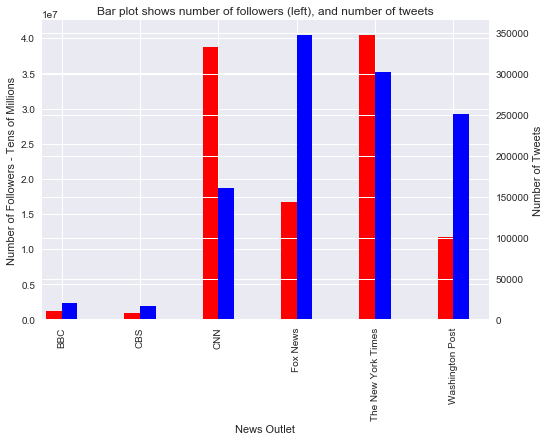

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.2

popular_news['Followers'].plot(kind='bar', color='red', ax=ax, width=width, position=1)
popular_news['Tweets'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Number of Followers - Tens of Millions')
ax2.set_ylabel('Number of Tweets')
ax.set_xlabel('News Outlet')

plt.title('Bar plot shows number of followers (left), and number of tweets')

plt.savefig('Bar plot_number followers_tweets')
plt.show()

In [8]:
# making dir for porper label real name vs. screen name 

real_name=popular_news.reset_index()['Real Name'].tolist()
scre_name=popular_news.reset_index()['Screen Name'].tolist()

real_name_dir={}

for i in range(len(real_name)):
    real_name_dir[scre_name[i]]=real_name[i]

real_name_dir



{'BBC': 'BBC',
 'CBS': 'CBS',
 'CNN': 'CNN',
 'FoxNews': 'Fox News',
 'nytimes': 'The New York Times',
 'washingtonpost': 'Washington Post'}

In [9]:
# Target User
#news_outlets =('BBC', 'CBS', 'CNN', 'FoxNews', 'nytimes', 'washingtonpost' ) 

#Create Dir to hold extracted data 
sentement_scores={}

for news_outlet in news_outlets:

    # Place holders 
    date_time=[]
    tweet_texts =[]
    compounds=   [] 
    neg_score=   []
    pos_score=   []
    neu_score=   []
    tweet_num=   []

    # Create a loop to iteratively run API requests
    num=1
    for tweet_page in range(1,6):

        # Get all tweets from home feed (for each page specified)
        public_tweets = api.user_timeline(news_outlet, page=tweet_page)

        # Loop through all tweets
        for tweet in public_tweets:


            # tweet Number 
            tweet_num.append(num)
            num+=1
            # Print Tweet
            #print(tweet["text"])
            
            #extract date 
            date_time.append(tweet['created_at'])

            # Store Tweet in Array
            tweet_texts.append(tweet["text"])
            
            # store veda in array 
            compound=analyzer.polarity_scores(tweet["text"])['compound']
            
            #print(compound)
            compounds.append(compound)
            
            neg=analyzer.polarity_scores(tweet["text"])['neg']
            neg_score.append(neg)
            
            # print most neg news
            if neg > .5:
                print(tweet["text"])
                print(news_outlet)
                print(f'Negative News Score (0 to 1) : {neg}')
                print('__')
                

            
            pos=analyzer.polarity_scores(tweet["text"])['pos']
            pos_score.append(pos)
            
            # print most pos news 
            if pos > .5:
                print(tweet["text"])
                print(news_outlet)
                print(f'Positive News Score (0 to 1): {pos}')
                print('__')
            
            neu=analyzer.polarity_scores(tweet["text"])['neu']
            neu_score.append(neu)
    
    #Dirctory with all data for the current news outlet 
    sentement_scores[news_outlet]=(tweet_num, date_time, compounds, neg_score, pos_score, neu_score, tweet_texts)

❄️ Happy holidays from CBS! ❄️  #fullbobble https://t.co/Xef9fKoPTv
CBS
Positive News Score (0 to 1): 0.524
__
Star comedian @JimCarrey gets emotional when he expresses his heartfelt thanks to Carol Burnett for her positive in… https://t.co/5QCejBcg5T
CBS
Positive News Score (0 to 1): 0.504
__
RT @junerenee: A true classic and favorite!! Love #CarolBurnett50 laughed and cried...just like before!
CBS
Positive News Score (0 to 1): 0.672
__
RT @RDMichelleLNK: Loving a dose of #BrunoMars midweek. So amazing!
CBS
Positive News Score (0 to 1): 0.542
__
A Kentucky lawmaker accused of sexually assaulting a teenage girl in 2013 died in a probable suicide Wednesday, a d… https://t.co/9RwthN5KTk
CNN
Negative News Score (0 to 1) : 0.511
__
A Kentucky lawmaker accused of sexually assaulting a teenage girl in 2013 died in a probable suicide Wednesday, a d… https://t.co/2gUwPlAMgz
CNN
Negative News Score (0 to 1) : 0.511
__
Man arrested in 1989 rape, murder of Washington state teenager (via @travfed)

In [10]:
# a function to to make data frame for each news outlet data 

def pol_df(news_outlet):
    scores={'Tweet_number': sentement_scores[news_outlet][0],
            'Date':sentement_scores[news_outlet][1],
            'Compound':sentement_scores[news_outlet][2],
            'Negative':sentement_scores[news_outlet][3],
            'Positive':sentement_scores[news_outlet][4],
            'Neutral':sentement_scores[news_outlet][5],
            'Tweet':sentement_scores[news_outlet][6],
            'News_outlet': news_outlet
           }
    return(pd.DataFrame(scores)) 

In [11]:
# create empty data frame 
cols=['News_outlet', 'Tweet_number', 'Date', 'Positive',  'Negative', 'Neutral', 'Compound', 'Tweet']
news_outlets_sentements = pd.DataFrame(columns=cols)

In [12]:
for news_outlet in news_outlets:
    news_outlet_data=pol_df(news_outlet)
    news_outlets_sentements = news_outlets_sentements.append(news_outlet_data)

In [13]:
news_outlets_sentements.reset_index(drop=True, inplace=True)

In [14]:
raw_date=news_outlets_sentements['Date'].tolist()
dates=[datetime.strptime(raw_stamp, "%a %b %d %H:%M:%S %z %Y") for raw_stamp in raw_date]
dates_array=np.asarray(dates)
#pd.Series(test3)
news_outlets_sentements.insert(0, 'Date_time', dates_array)


#drop old raw date 
news_outlets_sentements.drop('Date', axis=1, inplace=True)

In [15]:
#QC Step 
news_outlets_sentements.head() # check data - should have all the outles . head  

,Date_time,Compound,Negative,Neutral,News_outlet,Positive,Tweet,Tweet_number
0,2017-12-14 18:00:33+00:00,0.4019,0.000,0.863,BBC,0.137,🍠🥕🥑 Here are our favourite vegetarian dishes t...,1
1,2017-12-14 17:30:10+00:00,0.5859,0.073,0.682,BBC,0.245,👽 'Ask them if they believe in aliens' + 6 oth...,2
2,2017-12-14 17:00:05+00:00,0.0000,0.000,1.000,BBC,0.000,🙄\nLooking up or rolling eyes?\n\nVia @BBCScot...,3
3,2017-12-14 14:00:08+00:00,0.0000,0.000,1.000,BBC,0.000,🎞🎵🎨 Gospel singer and civil rights activist @M...,4
4,2017-12-14 13:30:06+00:00,0.0000,0.000,1.000,BBC,0.000,"🎄 @LiamPayne, @ddlovato &amp; @Camila_Cabello ...",5


In [16]:
#QC Step 
news_outlets_sentements.tail() # check data - should have all the outles . tail for last news outlet  

,Date_time,Compound,Negative,Neutral,News_outlet,Positive,Tweet,Tweet_number
595,2017-12-14 06:40:03+00:00,0.5994,0.000,0.782,washingtonpost,0.218,Perspective: The beautiful lie Bruce Brown and...,96
596,2017-12-14 06:10:41+00:00,0.0000,0.000,1.000,washingtonpost,0.000,He was a renowned surgeon — until a doctor fou...,97
597,2017-12-14 05:53:54+00:00,-0.6705,0.314,0.686,washingtonpost,0.000,"Despite Trump’s ire, Ireland expects to avoid ...",98
598,2017-12-14 05:22:35+00:00,0.0772,0.000,0.915,washingtonpost,0.085,Many Alabama voters want Jones to represent th...,99
599,2017-12-14 04:51:03+00:00,-0.3400,0.211,0.789,washingtonpost,0.000,Opinion: The reckoning on Republican shameless...,100


In [17]:
# QC step 
news_outlets_sentements.shape # should have number of rows - for this case study 600 

(600, 8)

In [18]:
# QC step 
set(news_outlets_sentements['News_outlet'].tolist()) # check if all outlets are extracted and yes 6 of them 

{'BBC', 'CBS', 'CNN', 'FoxNews', 'nytimes', 'washingtonpost'}

In [19]:
# map the real name instd of screen name for proper labeling 
news_outlets_sentements['News_outlet'] = news_outlets_sentements['News_outlet'].map(real_name_dir)

In [20]:
news_outlets_sentements

,Date_time,Compound,Negative,Neutral,News_outlet,Positive,Tweet,Tweet_number
0,2017-12-14 18:00:33+00:00,0.4019,0.000,0.863,BBC,0.137,🍠🥕🥑 Here are our favourite vegetarian dishes t...,1
1,2017-12-14 17:30:10+00:00,0.5859,0.073,0.682,BBC,0.245,👽 'Ask them if they believe in aliens' + 6 oth...,2
2,2017-12-14 17:00:05+00:00,0.0000,0.000,1.000,BBC,0.000,🙄\nLooking up or rolling eyes?\n\nVia @BBCScot...,3
3,2017-12-14 14:00:08+00:00,0.0000,0.000,1.000,BBC,0.000,🎞🎵🎨 Gospel singer and civil rights activist @M...,4
4,2017-12-14 13:30:06+00:00,0.0000,0.000,1.000,BBC,0.000,"🎄 @LiamPayne, @ddlovato &amp; @Camila_Cabello ...",5
5,2017-12-14 13:03:04+00:00,0.1027,0.000,0.935,BBC,0.065,❄️⛄️ How cold can it get at work before you ca...,6
6,2017-12-14 12:46:06+00:00,0.0000,0.000,1.000,BBC,0.000,RT @BBCNewsround: What do the @UKRobotWars hou...,7
7,2017-12-14 12:45:09+00:00,0.4215,0.000,0.859,BBC,0.141,RT @BBC6Music: What was your favourite album o...,8
8,2017-12-14 12:30:04+00:00,-0.5719,0.251,0.749,BBC,0.000,The awkward moment when Graham gets the wrong ...,9
9,2017-12-14 12:27:47+00:00,0.0000,0.000,1.000,BBC,0.000,"RT @BBCNews: 53 adults, 18 children 💚\n#Grenfe...",10


In [21]:
news_outlets_sentements.to_csv('news_outlets_sentements.csv')

In [22]:
# dates for disply 
dates=news_outlets_sentements.Date_time.sort_values()
date_1st=dates.iloc[0]
date_end=dates.iloc[-1]
date_1st

Timestamp('2017-11-29 09:09:48+0000', tz='UTC')

In [23]:
date_start=f'{date_1st.month}/{date_1st.day}/{date_1st.year} {date_1st.hour}:{date_1st.minute}'
date_start

'11/29/2017 9:9'

In [24]:
date_end=f'{date_end.month}/{date_end.day}/{date_end.year} {date_end.hour}:{date_end.minute}'
date_end

'12/14/2017 18:13'

In [25]:
compund=news_outlets_sentements.pivot(index='Tweet_number', columns='News_outlet', values='Compound')

##  Sentiment Polarity Analysis of each news_outlet

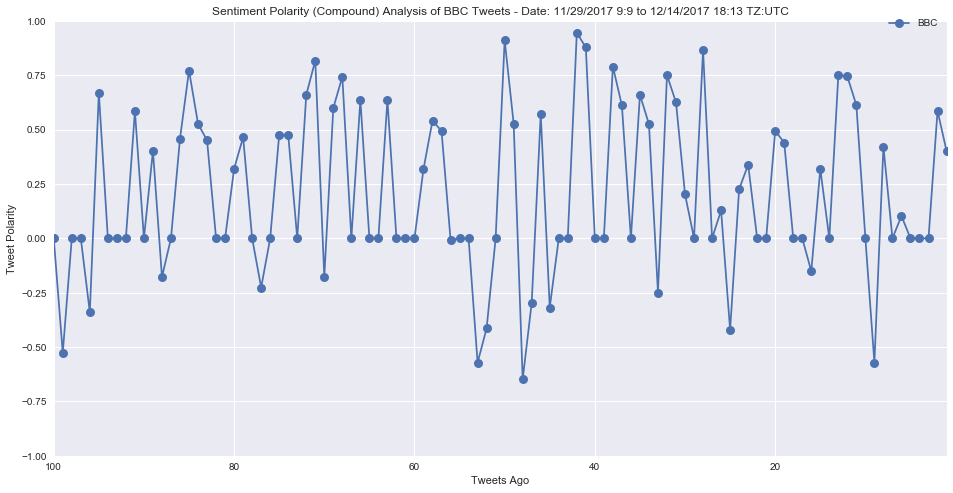

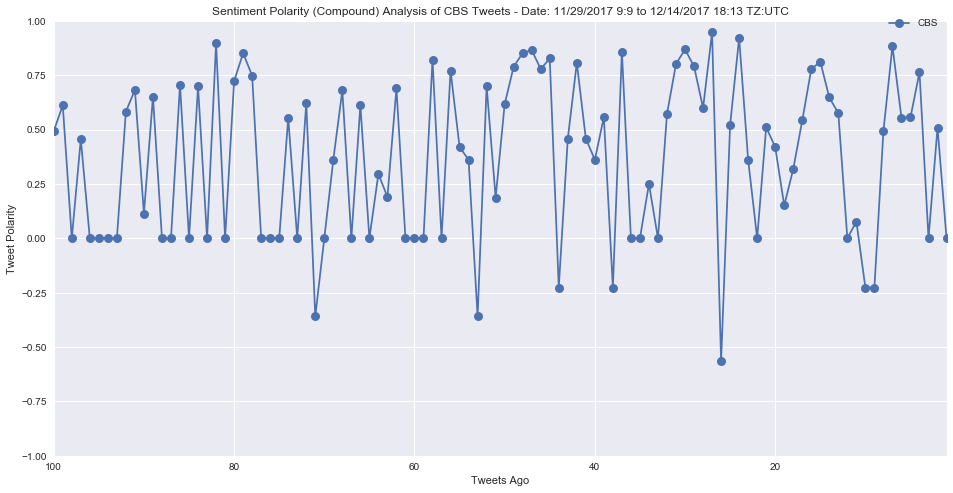

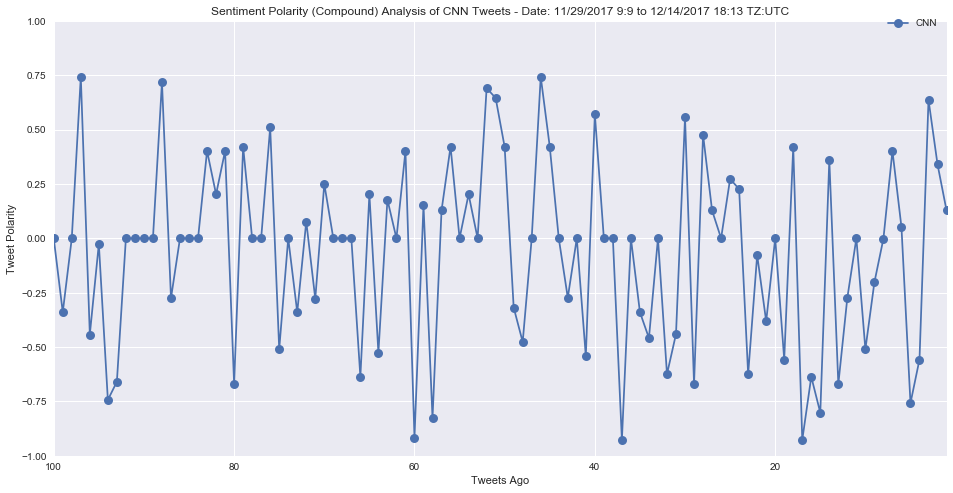

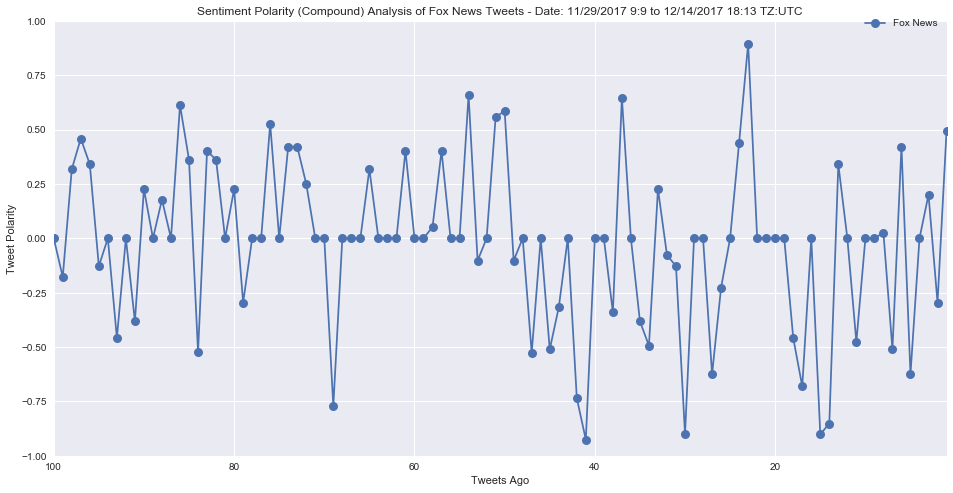

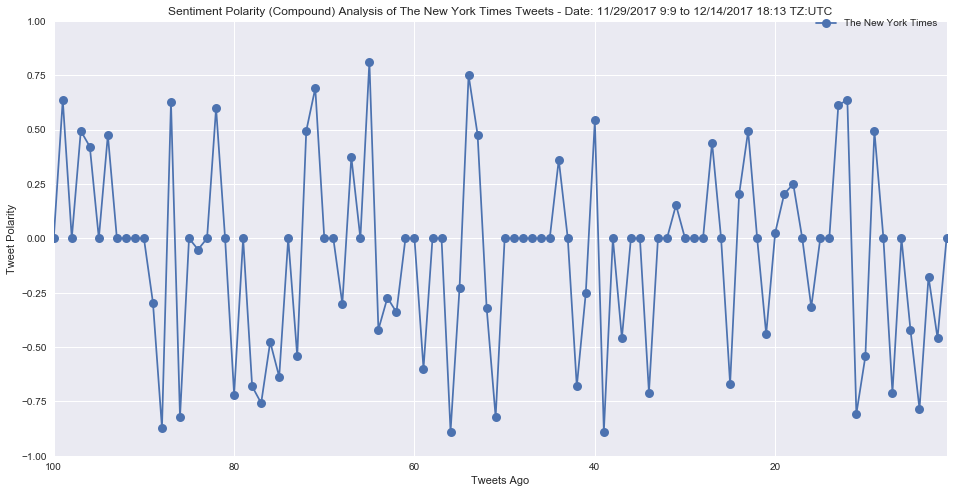

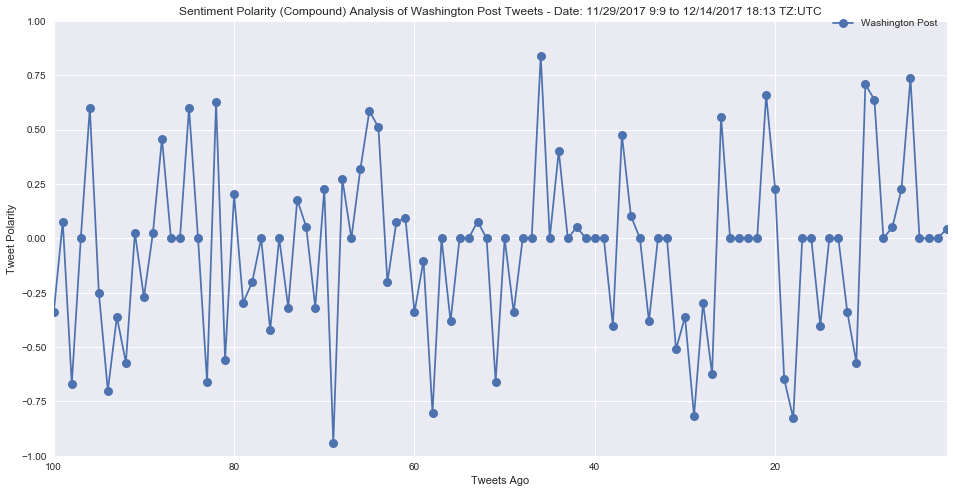

In [26]:
news_outlets=real_name
for news_outlet in news_outlets:
    compund[news_outlet].sort_index(ascending=False).plot(marker = 'o', grid=True,style='-', ms=9, figsize=(16,8))
    plt.legend(bbox_to_anchor=(1, 1.025))
    plt.xlabel('Tweets Ago')
    plt.ylabel('Tweet Polarity')
    plt.title(f'Sentiment Polarity (Compound) Analysis of {news_outlet} Tweets - Date: {date_start} to {date_end} TZ:UTC')
    plt.ylim(-1,1)
    plt.savefig(f'Sentiment Polarity Analysis {news_outlet}')

    plt.show();

##  Sentiment Polarity Analysis of all news_outlet

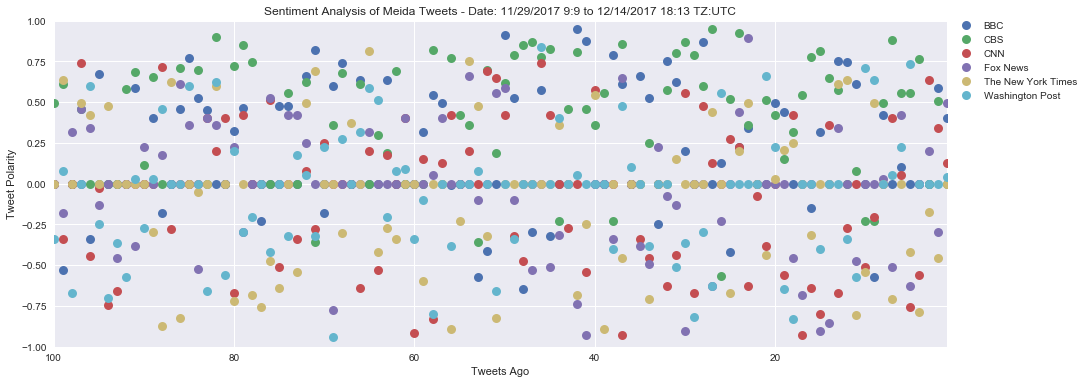

In [27]:
compund.sort_index(ascending=False).plot(marker = 'o', grid=True,style=' ', ms=9, figsize=(16,6))
plt.legend(bbox_to_anchor=(1, 1.025))
plt.xlabel('Tweets Ago')
plt.ylabel('Tweet Polarity')
plt.title(f'Sentiment Analysis of Meida Tweets - Date: {date_start} to {date_end} TZ:UTC')
plt.ylim(-1,1)
plt.savefig('Sentiment Polarity Analysis all news outlets')

plt.show();

##  Sentiment Polarity Analysis of all news_outlet Bar plot ( mean) and Swarmplot 

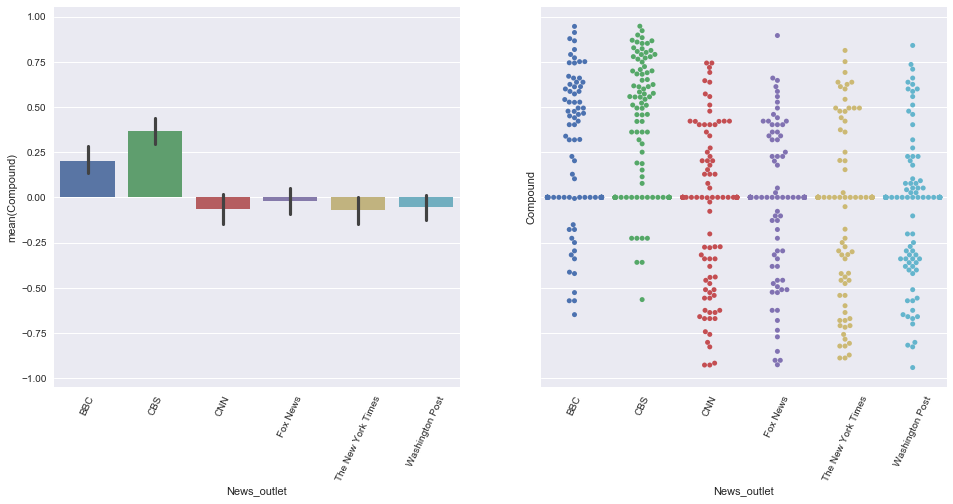

In [28]:
fig, axs = plt.subplots(ncols=2, figsize=(16,7), sharey=True)

a=sns.barplot(x='News_outlet', y='Compound', data=news_outlets_sentements, ax=axs[0])
for item in a.get_xticklabels():
    item.set_rotation(65)
b=sns.swarmplot(x='News_outlet', y='Compound', data=news_outlets_sentements, ax=axs[1])
for item in b.get_xticklabels():
    item.set_rotation(65)
plt.savefig('Bar Plots  - Swarm plot for Compound score')
plt.show()

## Kernel density estimaton - distribution of news outlets - compound score
Helps understand the data disputation
 

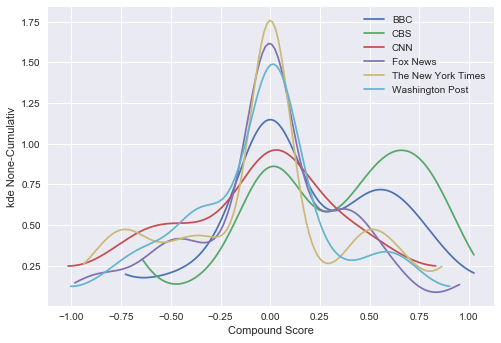

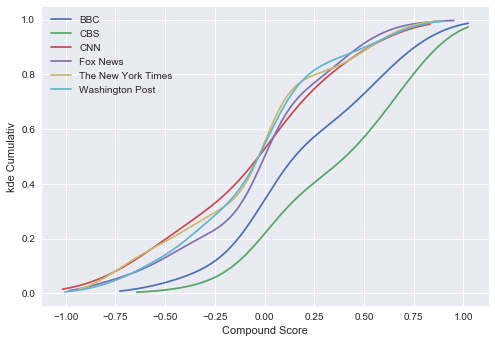

In [29]:
# create a histogram. By default it adds the kde (kernel density estimate)
for i in news_outlets:
    sns.kdeplot(compund[i], shade=False, cut=0.5, cumulative=False)
plt.xlabel('Compound Score')
plt.ylabel('kde None-Cumulativ')
plt.savefig('Kernel density estimaton')
plt.show()


# create a histogram. By default it adds the kde (kernel density estimate)
for i in news_outlets:
    sns.kdeplot(compund[i], shade=False, cut=0.5, cumulative=True)
plt.xlabel('Compound Score')
plt.ylabel('kde Cumulativ')
plt.savefig('Kernel density estimaton Cumulativ')
plt.show()



## Bar plot ( mean) Positive, Neutral and Negative sentements


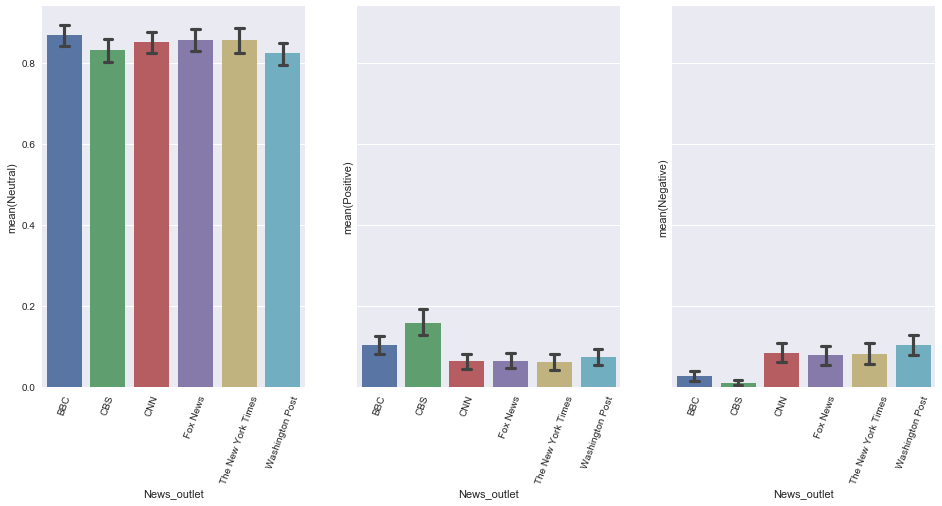

In [30]:
fig, axs = plt.subplots(ncols=3, figsize=(16,7), sharey=True)

a=sns.barplot(x='News_outlet', y='Neutral', data=news_outlets_sentements, ax=axs[0], capsize=.2)
for item in a.get_xticklabels():
    item.set_rotation(70)

b=sns.barplot(x='News_outlet', y='Positive', data=news_outlets_sentements, ax=axs[1] , capsize=.2)
for item in b.get_xticklabels():
    item.set_rotation(70)
    
c=sns.barplot(x='News_outlet', y='Negative', data=news_outlets_sentements, ax=axs[2], capsize=.2)
for item in c.get_xticklabels():
    item.set_rotation(70)
    
plt.savefig('Bar Plots All News Outlets')

plt.show()


## Sentiment score vs. Time Series plots  

In [31]:
def plot_time_scores(score):
    fig = plt.figure(figsize=(16,7))
    ax = fig.add_subplot(1, 1, 1)

    markers=['bo', 'go', 'ro', 'co', 'mo', 'ko']
    
    counter=0

    for news_outlet in news_outlets:
        data = news_outlets_sentements[news_outlets_sentements['News_outlet']==news_outlet]
        ax.plot(data.Date_time, data[score], markers[counter], label=news_outlet)
        counter+=1

    ax.legend()
    plt.title(f'Time vs Sentiment score ({score})')
    plt.xlabel('Time')
    plt.ylabel(f'{score} score')
    plt.savefig(f'timeS_Plots {score}')
    plt.show()

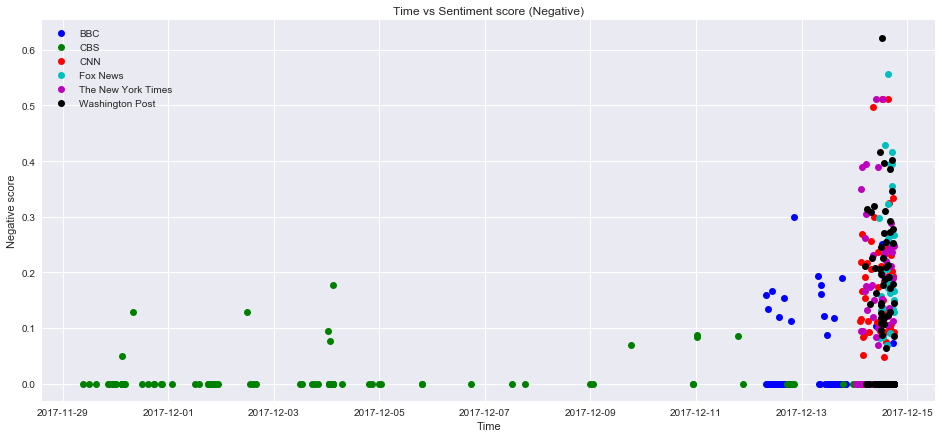

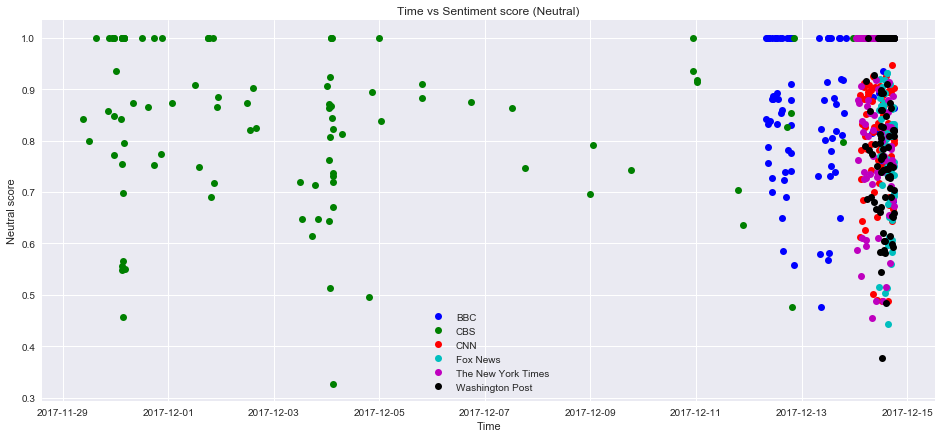

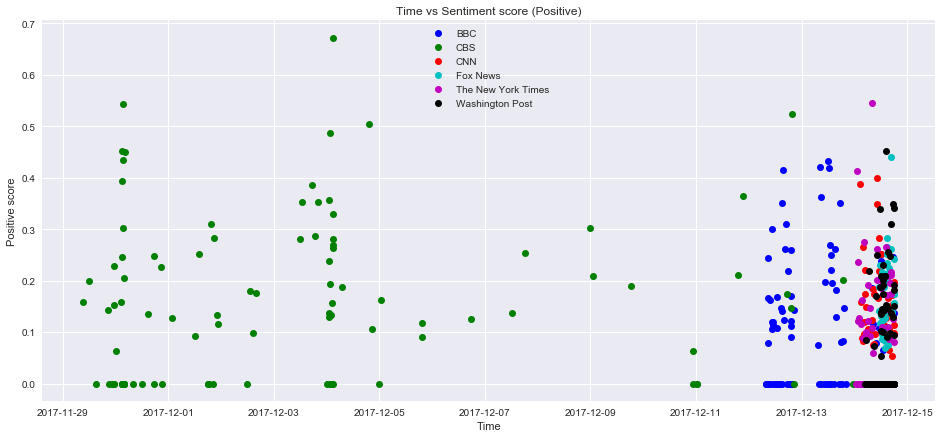

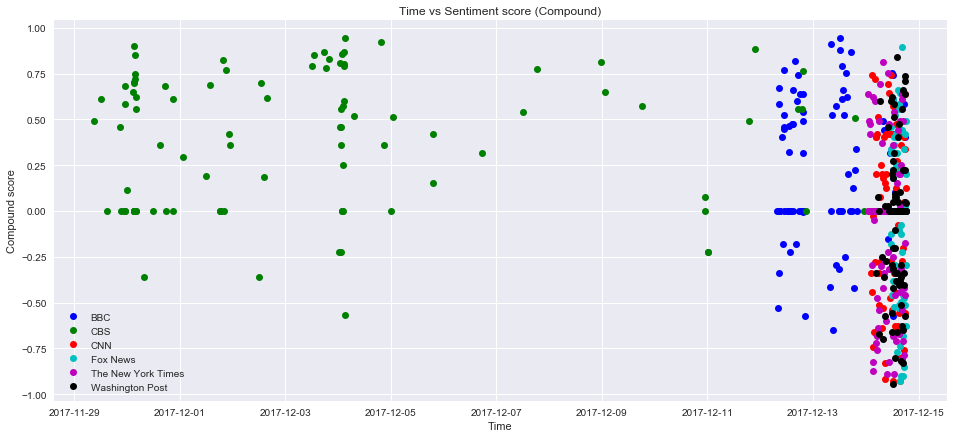

In [32]:
scores=['Negative', 'Neutral', 'Positive', 'Compound']
for score in scores:
    plot_time_scores(score)